<a href="https://colab.research.google.com/github/AditiAmbasta13/NER-and-Feature-Engineering-for-News-Articles-with-Fake-vs.-Real-Classification/blob/main/Banao_AI_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import re
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from collections import Counter
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('averaged_perceptron_tagger_eng')

gossipcop_fake = pd.read_csv('gossipcop_fake.csv')
gossipcop_real = pd.read_csv('gossipcop_real.csv')
politifact_fake = pd.read_csv('politifact_fake.csv')
politifact_real = pd.read_csv('politifact_real.csv')

gossipcop_fake['label'] = 'fake'
gossipcop_real['label'] = 'real'
politifact_fake['label'] = 'fake'
politifact_real['label'] = 'real'

# Combining datasets datasets
data = pd.concat([gossipcop_fake, gossipcop_real, politifact_fake, politifact_real], ignore_index=True)

data = data[['id', 'news_url', 'title', 'label']]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [ ]:
# --- Text Preprocessing ---
# Remove special characters, numbers, and convert to lowercase
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower()
    return text

data['cleaned_title'] = data['title'].apply(lambda x: preprocess_text(str(x)))

In [ ]:
# --- Tokenization and Stopword Removal ---
stop_words = set(stopwords.words('english'))
def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

data['processed_title'] = data['cleaned_title'].apply(tokenize_and_remove_stopwords)

In [ ]:
# --- Named Entity Recognition (NER) ---
nlp = spacy.load('en_core_web_sm')
def extract_entities(text):
    doc = nlp(text)
    entities = {
        'PERSON': 0,
        'ORG': 0,
        'GPE': 0
    }
    for ent in doc.ents:
        if ent.label_ in entities:
            entities[ent.label_] += 1
    return entities

# Apply NER and extract entity counts
data['entities'] = data['processed_title'].apply(extract_entities)
data['person_count'] = data['entities'].apply(lambda x: x['PERSON'])
data['org_count'] = data['entities'].apply(lambda x: x['ORG'])
data['gpe_count'] = data['entities'].apply(lambda x: x['GPE'])

In [ ]:
# --- Article Length ---
data['article_length'] = data['processed_title'].apply(lambda x: len(x.split()))

# --- Sentiment Analysis ---
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

data['sentiment_score'] = data['processed_title'].apply(get_sentiment)

In [ ]:
# --- Part-of-Speech (POS) Tagging ---
def get_pos_tags(text):
    tokens = word_tokenize(text)
    pos_counts = Counter(tag for word, tag in pos_tag(tokens))
    return pos_counts


pos_features = data['processed_title'].apply(get_pos_tags)
pos_df = pd.DataFrame(list(pos_features)).fillna(0)

# --- Readability Score ---
def compute_readability(text):
    word_count = len(text.split())
    sentence_count = text.count('.') + text.count('!') + text.count('?') or 1  # Avoid division by zero
    return word_count / sentence_count

data['readability_score'] = data['processed_title'].apply(compute_readability)

In [ ]:
# --- Unique Word Count ---
data['unique_word_count'] = data['processed_title'].apply(lambda x: len(set(x.split())))

# --- Label Encoding ---
label_mapping = {'real': 1, 'fake': 0}
data['label'] = data['label'].map(label_mapping)

# --- Combine Features ---
features = pd.concat([
    data[['person_count', 'org_count', 'gpe_count', 'article_length', 'sentiment_score', 'readability_score', 'unique_word_count']],
    pos_df
], axis=1).fillna(0)

y = data['label']

In [ ]:
# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.3, random_state=42)

# --- Model Training ---
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# --- Model Evaluation ---
y_pred = model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.22      0.30      1713
           1       0.78      0.93      0.85      5246

    accuracy                           0.75      6959
   macro avg       0.64      0.57      0.58      6959
weighted avg       0.71      0.75      0.72      6959

Confusion Matrix:
 [[ 369 1344]
 [ 369 4877]]


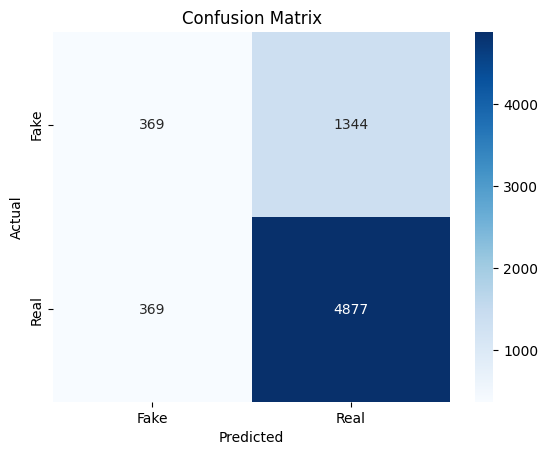

In [ ]:
# --- Confusion Matrix Visualization ---
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

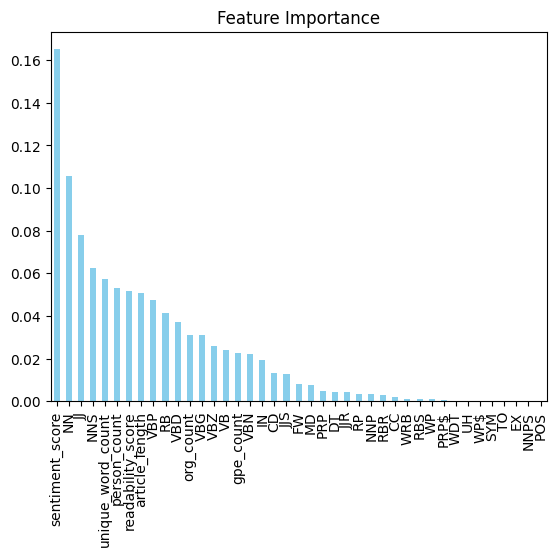

In [ ]:
# --- Feature Importance ---
feature_importances = pd.Series(model.feature_importances_, index=features.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Feature Importance')
plt.show()


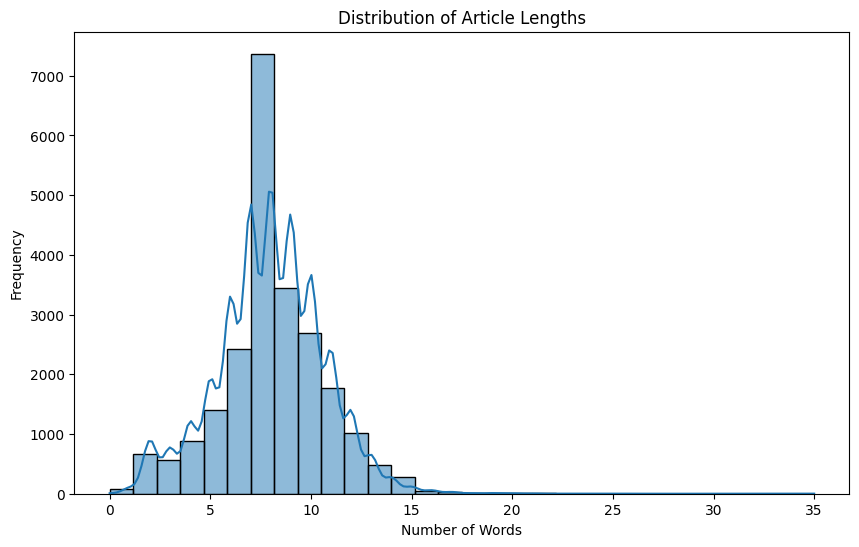

In [ ]:
# 1. Distribution of Article Lengths
plt.figure(figsize=(10, 6))
sns.histplot(data['article_length'], bins=30, kde=True)
plt.title('Distribution of Article Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

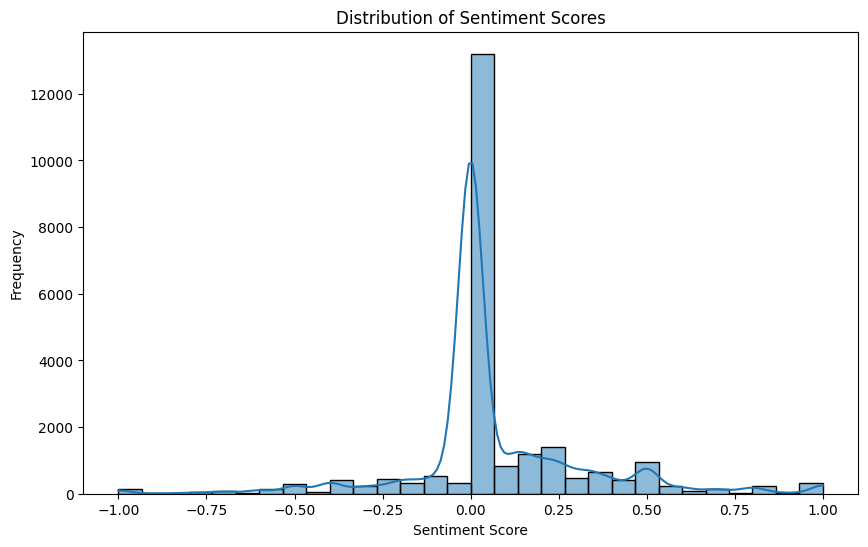

In [ ]:
# 2. Distribution of Sentiment Scores
plt.figure(figsize=(10, 6))
sns.histplot(data['sentiment_score'], bins=30, kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

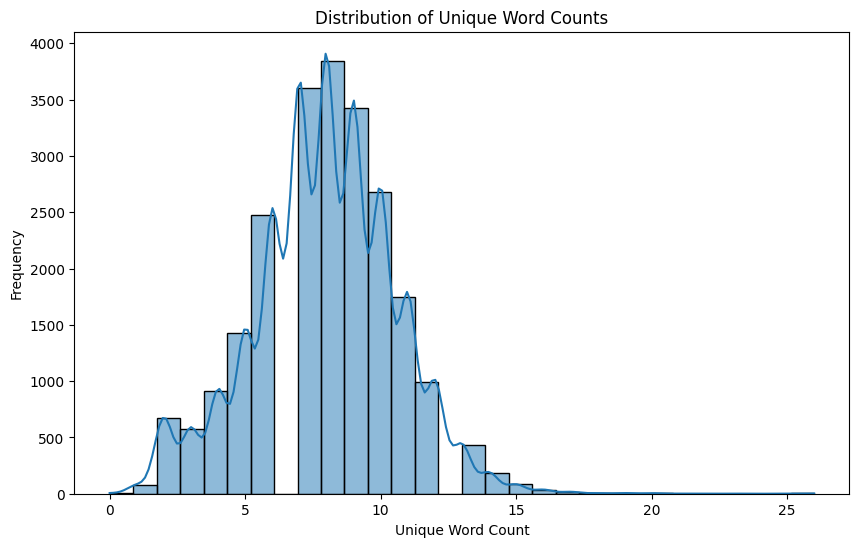

In [ ]:
# 3. Distribution of Unique Word Counts
plt.figure(figsize=(10, 6))
sns.histplot(data['unique_word_count'], bins=30, kde=True)
plt.title('Distribution of Unique Word Counts')
plt.xlabel('Unique Word Count')
plt.ylabel('Frequency')
plt.show()


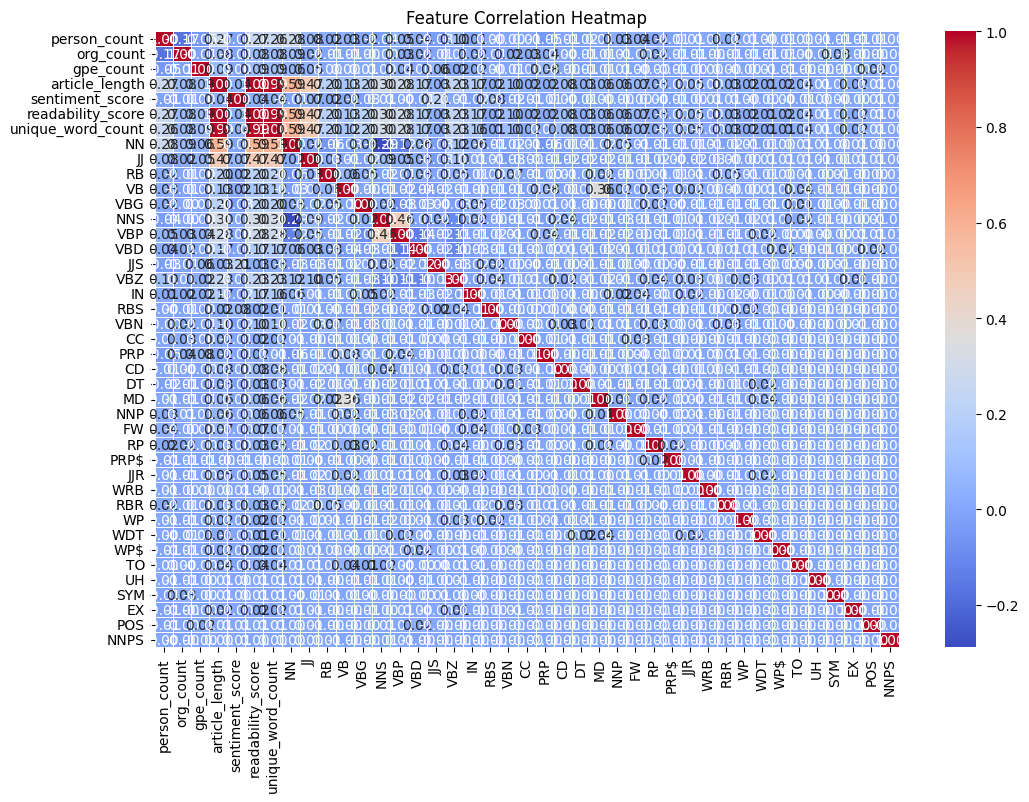

In [ ]:
# 4. Correlation Heatmap of Features
plt.figure(figsize=(12, 8))
corr_matrix = features.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

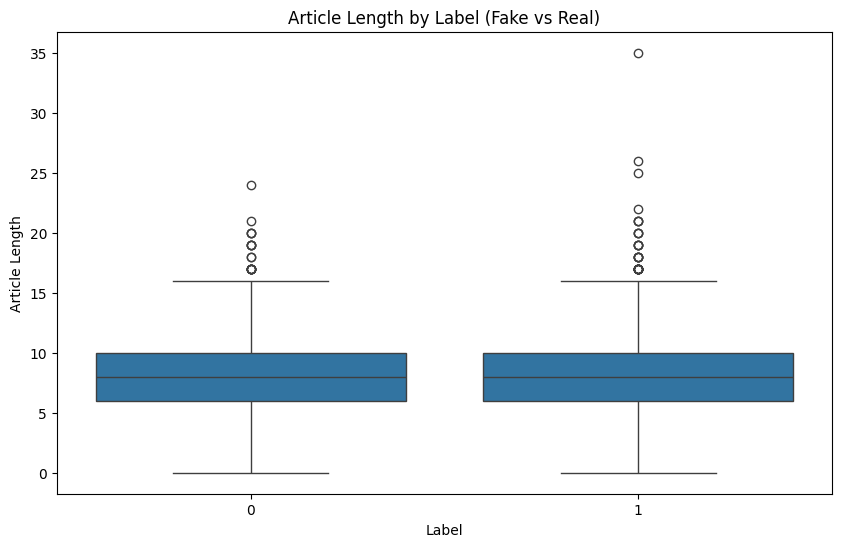

In [ ]:
# 5. Boxplot of Article Length by Label (Fake vs Real)
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='article_length', data=data)
plt.title('Article Length by Label (Fake vs Real)')
plt.xlabel('Label')
plt.ylabel('Article Length')
plt.show()

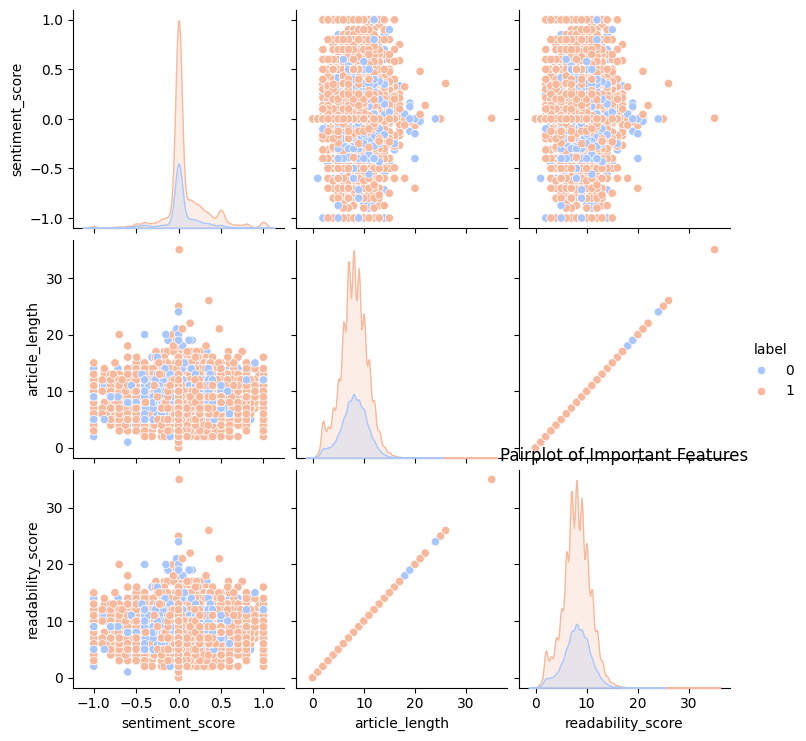

In [ ]:
# 6. Pairplot of Important Features (Sentiment, Article Length, and Readability)
important_features = data[['sentiment_score', 'article_length', 'readability_score', 'label']]
sns.pairplot(important_features, hue='label', palette='coolwarm')
plt.title('Pairplot of Important Features')
plt.show()

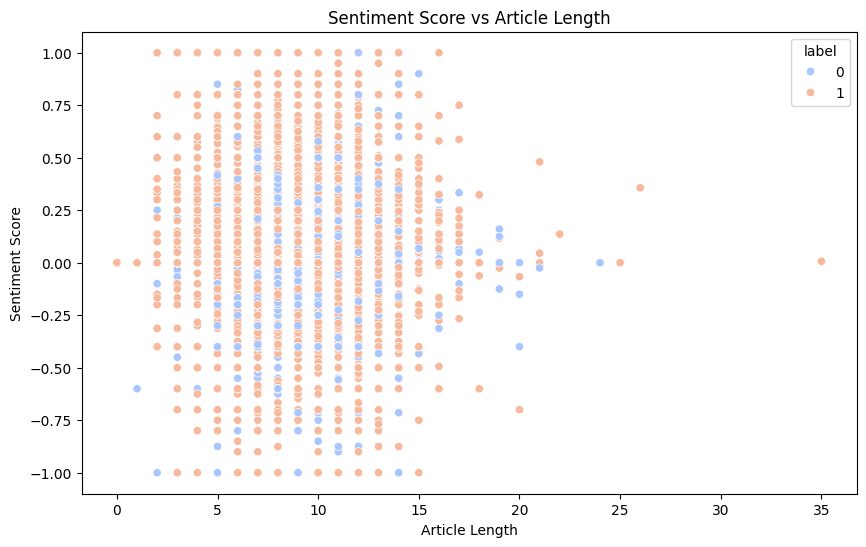

In [ ]:
# 7. Sentiment Score vs Article Length (Scatter Plot)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='article_length', y='sentiment_score', hue='label', data=data, palette='coolwarm')
plt.title('Sentiment Score vs Article Length')
plt.xlabel('Article Length')
plt.ylabel('Sentiment Score')
plt.show()

In [ ]:
# --- Save ---
data.to_csv('enhanced_news_data_with_features.csv', index=False)
print("Task completed: Enhanced data saved, model trained, and results visualized.")